In [1]:
import os
import librosa
import numpy as np
import soundfile
import IPython
import shutil
from IPython.display import Audio
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, LeakyReLU, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas
from tensorflow.keras.models import model_from_json
from scipy import stats
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import soundfile as sf

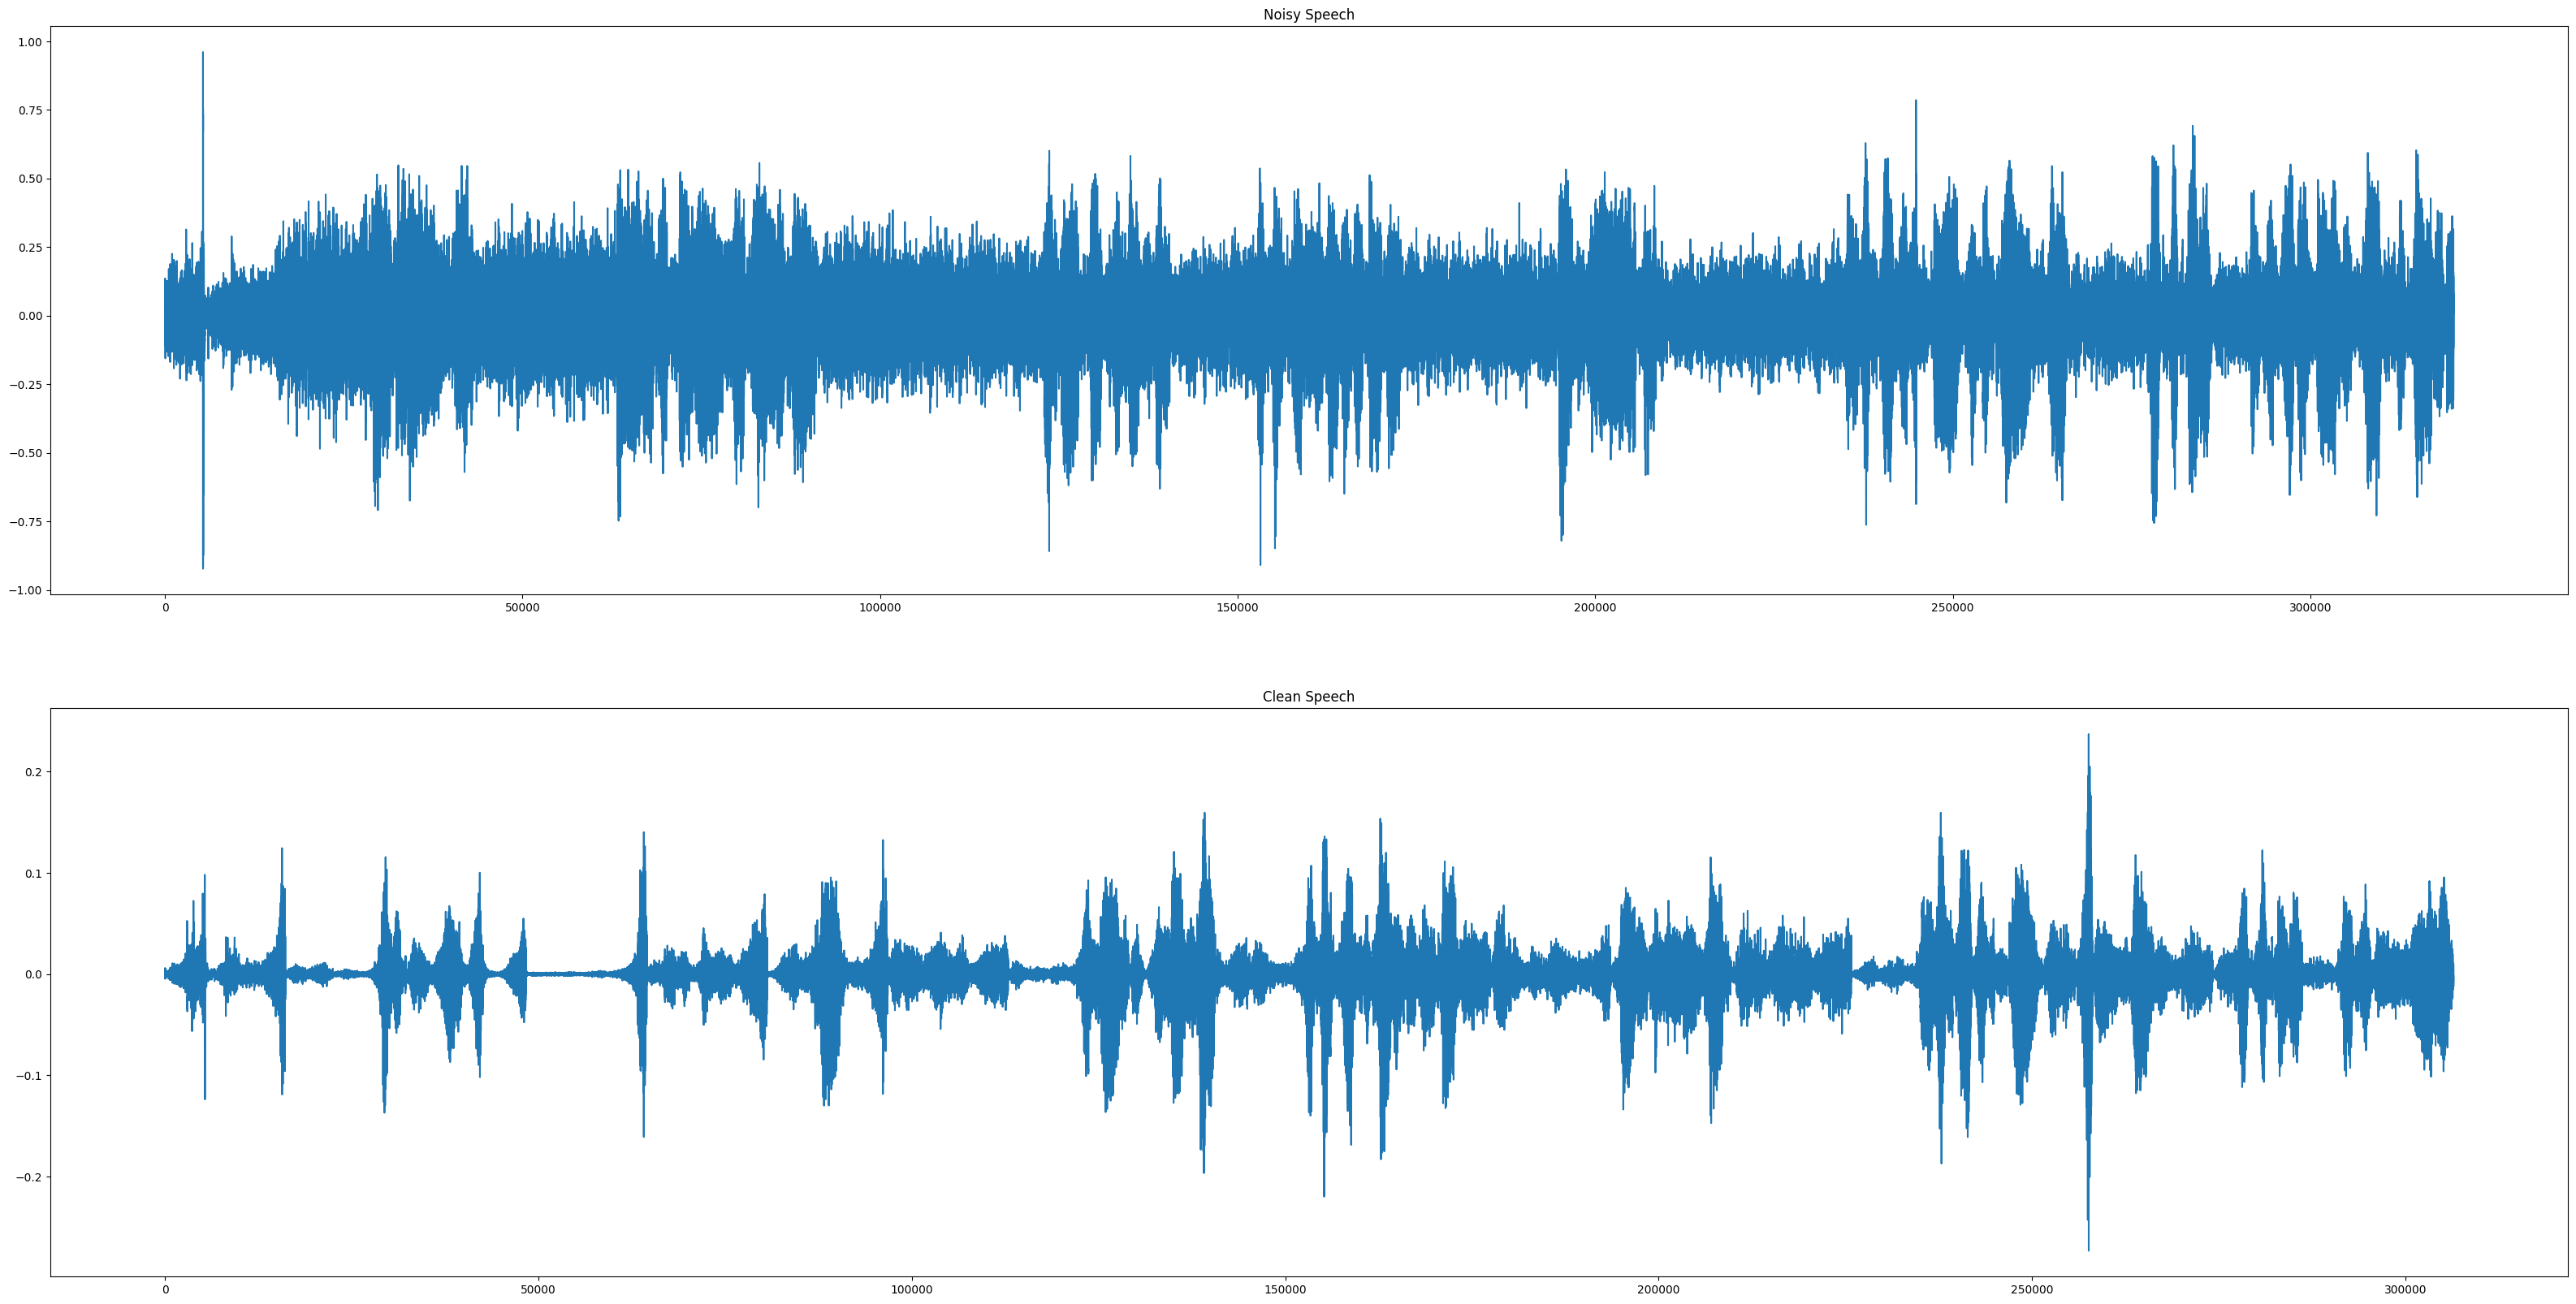

In [3]:
plt.figure(figsize=(40,20))
plt.subplot(211)
plt.title("Noisy Speech")
samples_noisy,sr=librosa.load("test_sound.wav",sr=16000)
plt.plot(samples_noisy)

plt.subplot(212)
plt.title("Clean Speech")
samples_clean,sr=librosa.load("test_sound_denoised.wav",sr=16000)
plt.plot(samples_clean)

plt.show()


In [2]:
#audio ko array(numpy) lai tukra tukra parera matrix banauni
def audio_to_audio_frame_stack(audio,frame_length,frame_hop_length):

    frame_stack_list=[]
    audio_length=audio.shape[0]
    for i in range(0,audio_length-frame_length+1,frame_hop_length):
        frame_stack_list.append(audio[i:i+frame_length])

    return np.vstack(frame_stack_list)


In [3]:
#clean ra noisy audio ko matrix lai mix garni
def blend_noise_randomly(clean_audio,noise,n_samples,frame_length):

    res_clean_audio=np.zeros((n_samples,frame_length))
    res_noise=np.zeros((n_samples,frame_length))
    res_noisy_audio=np.zeros((n_samples,frame_length))

    for i in range(n_samples):
        clean_audio_id=np.random.randint(0,clean_audio.shape[0])
        noise_id=np.random.randint(0,noise.shape[0])
        intensity=np.random.uniform(0.2,0.8)
        res_clean_audio[i]=clean_audio[clean_audio_id,:]
        res_noise[i]=intensity*noise[noise_id,:]
        res_noisy_audio[i]=res_clean_audio[i]+res_noise[i]

    return res_clean_audio,res_noise,res_noisy_audio




In [4]:
#audio ko matrix ko euta row ma stft garera mag ra phase nikalni

def audio_to_magnitude_db_and_phase(n_fft,hop_length_fft,audio):

    stft_audio=librosa.stft(audio,n_fft=n_fft,hop_length=hop_length_fft)
    stft_audio_magnitude,stft_audio_phase=librosa.magphase(stft_audio)

    stft_audio_magnitude_db=librosa.amplitude_to_db(stft_audio_magnitude,ref=np.max)
    return stft_audio_magnitude_db,stft_audio_phase


In [5]:
def audio_file_to_numpy(audio_path,sample_rate,frame_length, hop_length_frame,min_duration):

    y,sr=librosa.load(audio_path,sr=sample_rate)
    return np.vstack(audio_to_audio_frame_stack(y,frame_length,hop_length_frame))


In [6]:
#audio dir bhitra ka sabai audio files lai eutai matrix ma haleko
def audio_files_to_numpy(audio_dir,sample_rate,frame_length, hop_length_frame,min_duration):
    audio_file_list=os.listdir(audio_dir)
    list_audio_arrays=[]
    i=0
    for file in audio_file_list:
        i=i+1
        y,sr=librosa.load(os.path.join(audio_dir,file),sr=sample_rate)
        # print(y.shape)
        total_duration=librosa.get_duration(y=y,sr=sr)
        if(total_duration>=min_duration):
            list_audio_arrays.append(audio_to_audio_frame_stack(y,frame_length,hop_length_frame))
    print(i)
    return np.vstack(list_audio_arrays)



In [7]:
#audio ko sappai row ma stft laudai final euta matrix banauni
def numpy_audio_to_matrix_spectrogram(numpy_audio, n_fft, hop_length_fft):
    dim=int(n_fft/2)+1
    tot_rows=numpy_audio.shape[0]
    mag_matrix=np.zeros((tot_rows,dim,dim))
    phase_matrix=np.zeros((tot_rows,dim,dim),dtype=complex)
    for i in range (tot_rows):
        mag_matrix[i],phase_matrix[i]=audio_to_magnitude_db_and_phase(n_fft, hop_length_fft, numpy_audio[i])
    return mag_matrix,phase_matrix


In [8]:
#creating data
def create_data(noise_dir, voice_dir,path_save_spectrogram, sample_rate,
min_duration, frame_length, hop_length_frame, hop_length_frame_noise, nb_samples, n_fft, hop_length_fft):


    noise=audio_files_to_numpy(noise_dir,sample_rate,frame_length, hop_length_frame_noise,min_duration)
    print(noise.shape)
    voice=audio_files_to_numpy(voice_dir,sample_rate,frame_length,hop_length_frame,min_duration)
    print(voice.shape)
    for i in range(50):
        res_voice,res_noise,res_mixed=blend_noise_randomly(voice,noise,nb_samples,frame_length)#n_samples
      # print(res_mixed.shape)
        voice_amp_matrix,voice_phase_matrix=numpy_audio_to_matrix_spectrogram(res_voice, n_fft, hop_length_fft)
        noise_amp_matrix,noise_phase_matrix=numpy_audio_to_matrix_spectrogram(res_noise,  n_fft, hop_length_fft)
        mixed_amp_matrix,mixed_phase_matrix=numpy_audio_to_matrix_spectrogram(res_mixed,  n_fft, hop_length_fft)

        np.save(path_save_spectrogram+ f"{i}" + 'voice_amp_db', voice_amp_matrix)
        np.save(path_save_spectrogram+ f"{i}"+ 'noise_amp_db', noise_amp_matrix)             #Not required
        np.save(path_save_spectrogram +f"{i}"+ 'noisy_voice_amp_db', mixed_amp_matrix)
        print(f"done{i}")
        del voice_amp_matrix
        del voice_phase_matrix
        del noise_amp_matrix
        del noise_phase_matrix
        del mixed_amp_matrix
        del mixed_phase_matrix


In [9]:

noise_dir="noise/"
voice_dir="clean_speech/"
path_save_spectrogram="spectogram1/"
# !mkdir spectrogram1
sample_rate=16000
min_duration=1.0
frame_length=16128
hop_length_frame=16128
hop_length_frame_noise=16128
nb_samples=500
n_fft=511
hop_length_fft=63


In [ ]:
create_data(noise_dir=noise_dir,voice_dir=voice_dir,
            path_save_spectrogram=path_save_spectrogram,
            sample_rate=sample_rate,min_duration=min_duration,frame_length=frame_length,hop_length_frame=hop_length_frame,hop_length_frame_noise=hop_length_frame_noise,nb_samples=nb_samples,n_fft=n_fft,hop_length_fft=hop_length_fft)


In [10]:
# Unet network
def unet(input_size = (256,256,1)):
    #size filter input
    size_filter_in = 16
    #normal initialization of weights
    kernel_init = 'he_normal'
    #To apply leaky relu after the conv layer
    activation_layer = None
    inputs = Input(input_size)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(inputs)
    conv1 = LeakyReLU()(conv1)
    conv1 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv1)
    conv1 = LeakyReLU()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool1)
    conv2 = LeakyReLU()(conv2)
    conv2 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv2)
    conv2 = LeakyReLU()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool2)
    conv3 = LeakyReLU()(conv3)
    conv3 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv3)
    conv3 = LeakyReLU()(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool3)
    conv4 = LeakyReLU()(conv4)
    conv4 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv4)
    conv4 = LeakyReLU()(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(pool4)
    conv5 = LeakyReLU()(conv5)
    conv5 = Conv2D(size_filter_in*16, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv5)
    conv5 = LeakyReLU()(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(size_filter_in*8, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(drop5))
    up6 = LeakyReLU()(up6)
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge6)
    conv6 = LeakyReLU()(conv6)
    conv6 = Conv2D(size_filter_in*8, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv6)
    conv6 = LeakyReLU()(conv6)
    up7 = Conv2D(size_filter_in*4, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv6))
    up7 = LeakyReLU()(up7)
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge7)
    conv7 = LeakyReLU()(conv7)
    conv7 = Conv2D(size_filter_in*4, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv7)
    conv7 = LeakyReLU()(conv7)
    up8 = Conv2D(size_filter_in*2, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv7))
    up8 = LeakyReLU()(up8)
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge8)
    conv8 = LeakyReLU()(conv8)
    conv8 = Conv2D(size_filter_in*2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv8)
    conv8 = LeakyReLU()(conv8)

    up9 = Conv2D(size_filter_in, 2, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(UpSampling2D(size = (2,2))(conv8))
    up9 = LeakyReLU()(up9)
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(merge9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(size_filter_in, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv9 = Conv2D(2, 3, activation = activation_layer, padding = 'same', kernel_initializer = kernel_init)(conv9)
    conv9 = LeakyReLU()(conv9)
    conv10 = Conv2D(1, 1, activation = 'tanh')(conv9)

    model = Model(inputs,conv10)

    model.compile(optimizer = 'adam', loss = tf.keras.losses.MeanSquaredError(), metrics = ['mae'])
    #model.summary()
    return model


In [16]:
def scaled_in(matrix_spec):
    "global scaling apply to noisy voice spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec + 46)/50
#     matrix_spec = (matrix_spec )/80

    return matrix_spec
def scaled_ou(matrix_spec):
    "global scaling apply to noise models spectrograms (scale between -1 and 1)"
    matrix_spec = (matrix_spec -6 )/82
#     matrix_spec = (matrix_spec  )/82
    
    return matrix_spec


In [11]:
weights_path='./weights1'
batch_size=10
history=[]

In [ ]:
generator_nn=unet()
checkpoint = ModelCheckpoint(weights_path+'/model_unet_best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='auto')

generator_nn.summary()

for actual_epoch in range(2):
    for i in range(25):
        epochs=1
        print(f"i={i}")
#load noisy voice & clean voice spectrograms created by data_creation mode
        X_in = np.load(path_save_spectrogram +f"{i}"+'noisy_voice_amp_db'+".npy")
        X_ou = np.load(path_save_spectrogram +f"{i}"+'voice_amp_db'+".npy")
    #Model of noise to predict
        X_ou = X_in - X_ou

  

    #to scale between -1 and 1
        X_in = scaled_in(X_in)
        X_ou = scaled_ou(X_ou)
#     max_val=np.max(np.abs(X_in))
#     X_in=X_in/max_val
#     X_ou=X_ou/max_val


    #Reshape for training
        X_in = X_in[:,:,:]
        X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
        X_ou = X_ou[:,:,:]
        X_ou = X_ou.reshape(X_ou.shape[0],X_ou.shape[1],X_ou.shape[2],1)
    
        X_train, X_test, y_train, y_test = train_test_split(X_in, X_ou, test_size=0.10, random_state=42)

        del X_in
        del X_ou


    #Training
        history.append(generator_nn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, shuffle=True, callbacks=[checkpoint], verbose=1, validation_data=(X_test, y_test)))
        model_in_json = generator_nn.to_json()
        del X_train
        del X_test
        del y_train
        del y_test

    #Saving Model
        with open(weights_path+'/model_unet.json','w') as json_file:
            json_file.write(model_in_json)

    

In [ ]:
val_loss_graph=[]
train_loss_graph=[]
for i in range (50):
    val_loss_graph.append(history[i].history['val_loss'])
    train_loss_graph.append(history[i].history['loss'])

In [17]:
#Helper Functions
def magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, stftaudio_magnitude_db, stftaudio_phase):
 

    stftaudio_magnitude_rev = librosa.db_to_amplitude(stftaudio_magnitude_db, ref=1.0)

    # taking magnitude and phase of audio
    audio_reverse_stft = stftaudio_magnitude_rev * stftaudio_phase
    audio_reconstruct = librosa.core.istft(audio_reverse_stft, hop_length=hop_length_fft, length=frame_length)

    return audio_reconstruct


def matrix_spectrogram_to_numpy_audio(m_mag_db, m_phase, frame_length, hop_length_fft)  :
  

    list_audio = []

    nb_spec = m_mag_db.shape[0]

    for i in range(nb_spec):

        audio_reconstruct = magnitude_db_and_phase_to_audio(frame_length, hop_length_fft, m_mag_db[i], m_phase[i])
        list_audio.append(audio_reconstruct)

    return np.vstack(list_audio)

def inv_scaled_ou(matrix_spec):
    
#     matrix_spec = matrix_spec * 40 - 40
    matrix_spec = matrix_spec * 82 + 6
#     matrix_spec = matrix_spec * 80 

    return matrix_spec



In [18]:
def noise_estimation(noisy_speech, n_fft, hop_length_fft):

    stft_noisy_speech = librosa.stft(noisy_speech, n_fft=n_fft, hop_length=hop_length_fft)
    
    # Compute the magnitude spectrum of the noisy speech
    stft_noisy_speech_magnitude,stft_noisy_speech_phase=librosa.magphase(stft_noisy_speech)

#     stft_noisy_speech_magnitude_db=librosa.amplitude_to_db(stft_noisy_speech_magnitude)
    
#     stft_noisy_speech_magnitude_db_copy=np.copy(stft_noisy_speech_magnitude_db)
    stft_noisy_speech_magnitude_copy=np.copy(stft_noisy_speech_magnitude)
    
    stft_noisy_speech_magnitude_copy[stft_noisy_speech_magnitude_copy==0]=np.inf
    
    noise_magnitude = np.min(stft_noisy_speech_magnitude_copy, axis=1)
    
#     noise_magnitude=np.abs(noise_magnitude)
    del stft_noisy_speech_magnitude_copy
# del stft_noisy_speech_magnitude_db_copy
#     print(noise_magnitude)
#     print (stft_noisy_speech_magnitude_db.shape)
#     print(stft_noisy_speech_phase.shape)
#     return noise_magnitude, stft_noisy_speech_magnitude_db,stft_noisy_speech_phase
    return noise_magnitude, stft_noisy_speech_magnitude,stft_noisy_speech_phase






In [30]:
audio_input_for_prediction='test_data/test_sound'

dir_save_prediction=""
audio_output_spec_subs=audio_input_for_prediction+'spec_denoised.wav'
audio_output_prediction=audio_input_for_prediction+'_denoised.wav'
weights_path='weights1'


In [31]:
# load json and create model
json_file = open(weights_path+'/model_unet.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model/
loaded_model.load_weights(weights_path+'/model_unet_best.h5')
print("Loaded model from disk")


noisy_speech,sample_rate=librosa.load(audio_input_for_prediction+'.wav',sr=sample_rate)
# noise_magnitude, stft_noisy_speech_magnitude_db,stft_noisy_speech_phase= noise_estimation(noisy_speech, n_fft,hop_length_fft)
noise_magnitude, stft_noisy_speech_magnitude,stft_noisy_speech_phase= noise_estimation(noisy_speech, n_fft,hop_length_fft)

# enhanced_speech_magnitude_db = np.copy(stft_noisy_speech_magnitude_db)
enhanced_speech_magnitude = np.copy(stft_noisy_speech_magnitude)

for i in range(enhanced_speech_magnitude.shape[0]):  # Loop through each frequency bin
    enhanced_speech_magnitude[i] = stft_noisy_speech_magnitude[i] - noise_magnitude[i]
    

# enhanced_speech_magnitude_db[enhanced_speech_magnitude_db<0]=0
enhanced_speech_magnitude[enhanced_speech_magnitude<0]=0

# print(enhanced_speech_magnitude_db.shape)
# enhanced_speech_magnitude = librosa.db_to_amplitude(enhanced_speech_magnitude_db)
# print(enhanced_speech_magnitude_db.shape)
audio_reverse_stft = enhanced_speech_magnitude * stft_noisy_speech_phase
print(audio_reverse_stft.shape)
# taking magnitude and phase of audio
audio_reconstruct = librosa.istft(audio_reverse_stft, hop_length=hop_length_fft)
print(audio_reconstruct.shape)
sf.write(dir_save_prediction + audio_output_spec_subs, audio_reconstruct, sample_rate, 'PCM_24')

    
audio=np.vstack(audio_to_audio_frame_stack(audio_reconstruct,frame_length,hop_length_frame))

dim_square_spec = int(n_fft / 2) + 1
print(dim_square_spec)

    # Create Amplitude and phase of the sounds
m_amp_db_audio,  m_pha_audio = numpy_audio_to_matrix_spectrogram(
        audio, n_fft, hop_length_fft)

    #global scaling to have distribution -1/1
X_in = scaled_in(m_amp_db_audio)
    #Reshape for prediction
X_in = X_in.reshape(X_in.shape[0],X_in.shape[1],X_in.shape[2],1)
    #Prediction using loaded network
X_pred = loaded_model.predict(X_in)
    #Rescale back the noise model
inv_sca_X_pred = inv_scaled_ou(X_pred)
    #Remove noise model from noisy speech
X_denoise = m_amp_db_audio - inv_sca_X_pred[:,:,:,0]
# X_denoise =inv_sca_X_pred[:,:,:,0]
    #Reconstruct audio from denoised spectrogram and phase
print(X_denoise.shape)
print(m_pha_audio.shape)
print(frame_length)
print(hop_length_fft)
audio_denoise_recons = matrix_spectrogram_to_numpy_audio(X_denoise, m_pha_audio, frame_length, hop_length_fft)
    #Number of frames
nb_samples = audio_denoise_recons.shape[0]
    #Save all frames in one file
denoise_long = (audio_denoise_recons.reshape(1, nb_samples * frame_length)*30)
    # librosa.output.write_wav(dir_save_prediction + audio_output_prediction, denoise_long[0, :], 1000)
sf.write(dir_save_prediction + audio_output_prediction, denoise_long[0, :], sample_rate, 'PCM_24')
    # wavfile.write(dir_save_prediction + audio_output_prediction, 1000, denoise_long[0,:])
print("done")


Loaded model from disk
(256, 3640)
(229257,)
256
1/1 [==============================] - 1s 1s/step
(14, 256, 256)
(14, 256, 256)
16128
63
done


In [21]:
Audio(audio_input_for_prediction+'.wav')

In [22]:
Audio(audio_input_for_prediction+'_denoised.wav')


In [37]:
noisy,_=librosa.load(audio_input_for_prediction+'.wav',sr=sample_rate)
print(noisy.shape)
clean,_=librosa.load(audio_input_for_prediction+'_denoised.wav',sr=sample_rate)

(229280,)


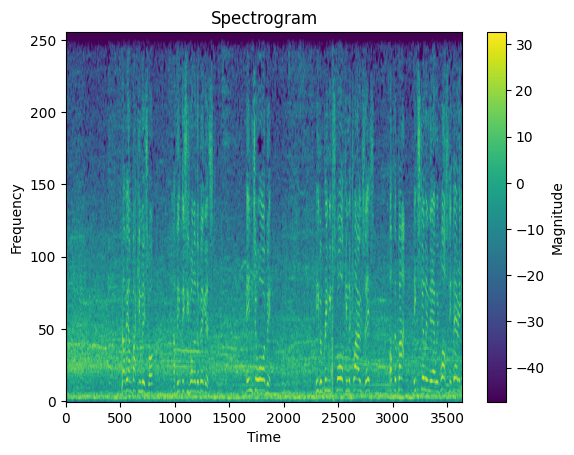

In [33]:
noisy_stft=librosa.stft(noisy, n_fft=n_fft, hop_length=hop_length_fft)
plt.imshow(librosa.amplitude_to_db(np.abs(noisy_stft)), aspect='auto', origin='lower', cmap='viridis')  # You might want to use np.abs() to plot the magnitude
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

(256, 3584)


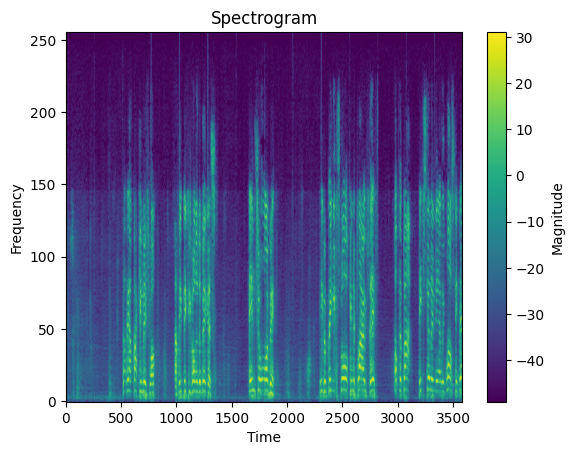

In [36]:
clean_stft=librosa.stft(clean, n_fft=n_fft, hop_length=hop_length_fft)
print(clean_stft.shape)
plt.imshow(librosa.amplitude_to_db(np.abs(clean_stft)), aspect='auto', origin='lower', cmap='viridis')  # You might want to use np.abs() to plot the magnitude
plt.colorbar(label='Magnitude')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()